In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! git clone https://github.com/YhBedoya/ImageMAE.git

Cloning into 'ImageMAE'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 107 (delta 61), reused 85 (delta 40), pack-reused 0
Receiving objects: 100% (107/107), 946.05 KiB | 18.19 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [4]:
!pip install timm=="0.3.2"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 244 kB 26.8 MB/s 


In [5]:
import os
os.chdir("/content/ImageMAE")

The following is a necessary fix in the file /usr/local/lib/python3.7/dist-packages/timm/models/layers/helpers.py



```
import torch
from itertools import repeat
TORCH_MAJOR = int(torch.__version__.split('.')[0])
TORCH_MINOR = int(torch.__version__.split('.')[1])

if TORCH_MAJOR == 1 and TORCH_MINOR < 8:
    from torch._six import container_abcs
else:
    import collections.abc as container_abcs
```



### Training phase

In [6]:
from main_pretrain import get_args_parser
from main_pretrain import main
from pathlib import Path

In [ ]:
args = get_args_parser()
args.add_argument('-f')
args = args.parse_args()

In [ ]:
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
main(args)

Not using distributed mode
[12:28:47.881122] job dir: /content/ImageMAE
[12:28:47.881261] Namespace(accum_iter=1,
batch_size=64,
blr=0.001,
data_path='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/',
device='cuda',
dist_on_itp=False,
dist_url='env://',
distributed=False,
epochs=400,
f='/root/.local/share/jupyter/runtime/kernel-1d5d2c26-3b18-4778-af0b-49d7b20865fc.json',
input_size=64,
local_rank=-1,
log_dir='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir',
lr=None,
mask_ratio=0.75,
min_lr=0.0,
model='mae_vit_large_patch16',
norm_pix_loss=False,
num_workers=10,
output_dir='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir',
pin_mem=True,
resume='',
seed=0,
start_epoch=0,
warmup_epochs=40,
weight_decay=0.05,
world_size=1)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:892: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


[12:29:25.791880] Dataset ImageFolder
    Number of datapoints: 3986
    Root location: /content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(64, 64), scale=(0.2, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
[12:29:25.793153] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7f90523af650>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[12:29:40.958585] Model = MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(8, 8), stride=(8, 8))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
   

In [ ]:
import sys
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import models_mae

In [ ]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

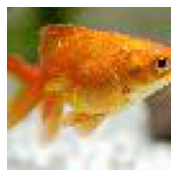

In [ ]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open("/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/val/n01443537/n01443537_402.JPEG")
img = img.resize((64, 64))
img = np.array(img)  / 256

assert img.shape == (64, 64, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [3, 3]
show_image(torch.tensor(img))

In [ ]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
#!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = '/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir/checkpoint.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

[15:56:01.620934] <All keys matched successfully>
[15:56:02.338282] Model loaded.


[15:56:05.785657] MAE with pixel reconstruction:


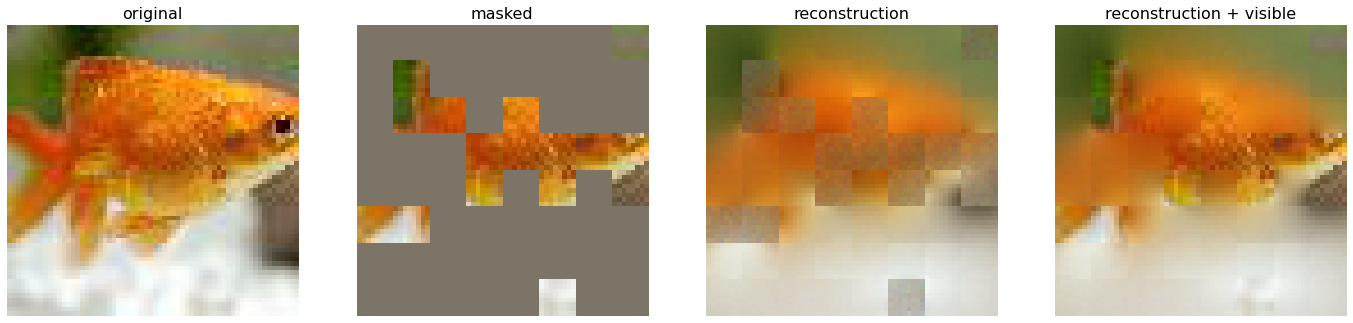

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Finetunning

In [7]:
from main_finetune import get_args_parser as get_args_parser_ft
from main_finetune import main as main_ft
from pathlib import Path

In [8]:
args = get_args_parser_ft()
args.add_argument('-f')
args = args.parse_args()

In [9]:
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)

In [10]:
main_ft(args)

Not using distributed mode
[17:36:08.392520] job dir: /content/ImageMAE
[17:36:08.393222] Namespace(aa='rand-m9-mstd0.5-inc1',
accum_iter=1,
batch_size=64,
blr=0.001,
clip_grad=None,
color_jitter=None,
cutmix=0,
cutmix_minmax=None,
data_path='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/',
device='cuda',
dist_eval=False,
dist_on_itp=False,
dist_url='env://',
distributed=False,
drop_path=0.1,
epochs=50,
eval=False,
f='/root/.local/share/jupyter/runtime/kernel-36714910-c4c1-4358-90b9-a75ba1b3462f.json',
finetune='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir/checkpoint.pth',
global_pool=True,
input_size=64,
layer_decay=0.75,
local_rank=-1,
log_dir='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir',
lr=None,
min_lr=1e-06,
mixup=0,
mixup_mode='batch',
mixup_prob=1.0,
mixup_switch_prob=0.5,
model='vit_large_patch16',
nb_classes=10,
num_workers=10,
out

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


[17:36:37.244507] Dataset ImageFolder
    Number of datapoints: 996
    Root location: /content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
[17:36:37.244925] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7f0b7eedb990>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[17:39:34.419063] Load pre-trained checkpoint from: /content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir/checkpoint.pth
[17:39:34.692128] _IncompatibleKeys(missing_keys=['head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'], unexpected_keys=['mask_token', 'decoder_pos_embed', 'norm.weight', 'norm.bias', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.att

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:40:07.811247] Epoch: [0]  [ 0/62]  eta: 0:27:03  lr: 0.000000  loss: 2.3026 (2.3026)  time: 26.1831  data: 17.9055  max mem: 5927
[17:40:33.639652] Epoch: [0]  [20/62]  eta: 0:01:44  lr: 0.000016  loss: 2.3021 (2.3018)  time: 1.2913  data: 0.5789  max mem: 9392
[17:41:04.967460] Epoch: [0]  [40/62]  eta: 0:00:44  lr: 0.000032  loss: 2.2987 (2.3000)  time: 1.5663  data: 0.8351  max mem: 9392
[17:41:37.655292] Epoch: [0]  [60/62]  eta: 0:00:03  lr: 0.000048  loss: 2.2912 (2.2967)  time: 1.6343  data: 0.8999  max mem: 9392
[17:41:38.387497] Epoch: [0]  [61/62]  eta: 0:00:01  lr: 0.000049  loss: 2.2908 (2.2966)  time: 1.6156  data: 0.8807  max mem: 9392
[17:41:39.026027] Epoch: [0] Total time: 0:01:57 (1.8936 s / it)
[17:41:39.027313] Averaged stats: lr: 0.000049  loss: 2.2908 (2.2966)
[17:41:56.711485] Test:  [ 0/16]  eta: 0:04:42  loss: 2.2557 (2.2557)  acc1: 50.0000 (50.0000)  time: 17.6798  data: 17.4292  max mem: 9392
[17:42:13.963325] Test:  [10/16]  eta: 0:00:19  loss: 2.2689 (2

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:42:19.933997] Epoch: [1]  [ 0/62]  eta: 0:03:13  lr: 0.000050  loss: 2.2890 (2.2890)  time: 3.1144  data: 2.3039  max mem: 9392
[17:42:34.769726] Epoch: [1]  [20/62]  eta: 0:00:35  lr: 0.000066  loss: 2.2701 (2.2723)  time: 0.7415  data: 0.0005  max mem: 9392
[17:42:49.710820] Epoch: [1]  [40/62]  eta: 0:00:17  lr: 0.000082  loss: 2.2481 (2.2608)  time: 0.7469  data: 0.0004  max mem: 9392
[17:43:04.798716] Epoch: [1]  [60/62]  eta: 0:00:01  lr: 0.000098  loss: 2.2260 (2.2479)  time: 0.7543  data: 0.0004  max mem: 9392
[17:43:05.555779] Epoch: [1]  [61/62]  eta: 0:00:00  lr: 0.000099  loss: 2.2245 (2.2470)  time: 0.7544  data: 0.0004  max mem: 9392
[17:43:06.338707] Epoch: [1] Total time: 0:00:49 (0.7988 s / it)
[17:43:06.338927] Averaged stats: lr: 0.000099  loss: 2.2245 (2.2470)
[17:43:09.053384] Test:  [ 0/16]  eta: 0:00:43  loss: 1.4839 (1.4839)  acc1: 85.9375 (85.9375)  time: 2.7077  data: 2.4326  max mem: 9392
[17:43:11.190751] Test:  [10/16]  eta: 0:00:02  loss: 2.2112 (2.105

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:43:16.096048] Epoch: [2]  [ 0/62]  eta: 0:03:15  lr: 0.000100  loss: 2.1712 (2.1712)  time: 3.1573  data: 2.3053  max mem: 9392
[17:43:31.288835] Epoch: [2]  [20/62]  eta: 0:00:36  lr: 0.000116  loss: 2.1317 (2.1297)  time: 0.7596  data: 0.0005  max mem: 9392
[17:43:46.671927] Epoch: [2]  [40/62]  eta: 0:00:18  lr: 0.000132  loss: 2.1158 (2.1315)  time: 0.7690  data: 0.0005  max mem: 9392
[17:44:02.136490] Epoch: [2]  [60/62]  eta: 0:00:01  lr: 0.000148  loss: 2.1137 (2.1268)  time: 0.7732  data: 0.0003  max mem: 9392
[17:44:02.910888] Epoch: [2]  [61/62]  eta: 0:00:00  lr: 0.000149  loss: 2.1137 (2.1266)  time: 0.7731  data: 0.0003  max mem: 9392
[17:44:03.677217] Epoch: [2] Total time: 0:00:50 (0.8184 s / it)
[17:44:03.678348] Averaged stats: lr: 0.000149  loss: 2.1137 (2.1266)
[17:44:06.290914] Test:  [ 0/16]  eta: 0:00:41  loss: 0.9125 (0.9125)  acc1: 87.5000 (87.5000)  time: 2.6086  data: 2.3280  max mem: 9392
[17:44:08.478488] Test:  [10/16]  eta: 0:00:02  loss: 2.0566 (1.958

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:44:13.281104] Epoch: [3]  [ 0/62]  eta: 0:03:07  lr: 0.000150  loss: 2.0122 (2.0122)  time: 3.0283  data: 2.2018  max mem: 9392
[17:44:28.747893] Epoch: [3]  [20/62]  eta: 0:00:36  lr: 0.000166  loss: 2.0345 (2.0388)  time: 0.7730  data: 0.0005  max mem: 9392
[17:44:44.230013] Epoch: [3]  [40/62]  eta: 0:00:18  lr: 0.000182  loss: 2.0911 (2.0631)  time: 0.7740  data: 0.0005  max mem: 9392
[17:44:59.746472] Epoch: [3]  [60/62]  eta: 0:00:01  lr: 0.000198  loss: 2.0627 (2.0665)  time: 0.7757  data: 0.0004  max mem: 9392
[17:45:00.525700] Epoch: [3]  [61/62]  eta: 0:00:00  lr: 0.000199  loss: 2.0627 (2.0669)  time: 0.7760  data: 0.0004  max mem: 9392
[17:45:01.279535] Epoch: [3] Total time: 0:00:51 (0.8230 s / it)
[17:45:01.279740] Averaged stats: lr: 0.000199  loss: 2.0627 (2.0669)
[17:45:03.518284] Test:  [ 0/16]  eta: 0:00:35  loss: 0.9783 (0.9783)  acc1: 82.8125 (82.8125)  time: 2.2305  data: 1.9354  max mem: 9392
[17:45:05.960785] Test:  [10/16]  eta: 0:00:02  loss: 1.9770 (1.893

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:45:11.545578] Epoch: [4]  [ 0/62]  eta: 0:03:21  lr: 0.000200  loss: 1.9174 (1.9174)  time: 3.2544  data: 2.3732  max mem: 9392
[17:45:27.271785] Epoch: [4]  [20/62]  eta: 0:00:37  lr: 0.000216  loss: 2.0082 (2.0139)  time: 0.7862  data: 0.0004  max mem: 9392
[17:45:42.995747] Epoch: [4]  [40/62]  eta: 0:00:18  lr: 0.000232  loss: 2.0533 (2.0267)  time: 0.7861  data: 0.0004  max mem: 9392
[17:45:58.678065] Epoch: [4]  [60/62]  eta: 0:00:01  lr: 0.000248  loss: 2.0335 (2.0335)  time: 0.7840  data: 0.0004  max mem: 9392
[17:45:59.460123] Epoch: [4]  [61/62]  eta: 0:00:00  lr: 0.000249  loss: 2.0335 (2.0350)  time: 0.7837  data: 0.0004  max mem: 9392
[17:46:00.208557] Epoch: [4] Total time: 0:00:51 (0.8374 s / it)
[17:46:00.208743] Averaged stats: lr: 0.000249  loss: 2.0335 (2.0350)
[17:46:02.664693] Test:  [ 0/16]  eta: 0:00:39  loss: 0.7562 (0.7562)  acc1: 85.9375 (85.9375)  time: 2.4495  data: 2.1877  max mem: 9392
[17:46:04.907885] Test:  [10/16]  eta: 0:00:02  loss: 1.9839 (1.849

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:46:09.644531] Epoch: [5]  [ 0/62]  eta: 0:03:03  lr: 0.000250  loss: 1.9375 (1.9375)  time: 2.9658  data: 2.1125  max mem: 9392
[17:46:25.372648] Epoch: [5]  [20/62]  eta: 0:00:37  lr: 0.000250  loss: 2.0012 (1.9964)  time: 0.7863  data: 0.0007  max mem: 9392
[17:46:41.187528] Epoch: [5]  [40/62]  eta: 0:00:18  lr: 0.000250  loss: 2.0249 (2.0117)  time: 0.7906  data: 0.0005  max mem: 9392
[17:46:57.003820] Epoch: [5]  [60/62]  eta: 0:00:01  lr: 0.000250  loss: 2.0174 (2.0150)  time: 0.7908  data: 0.0003  max mem: 9392
[17:46:57.789793] Epoch: [5]  [61/62]  eta: 0:00:00  lr: 0.000250  loss: 2.0174 (2.0165)  time: 0.7906  data: 0.0003  max mem: 9392
[17:46:58.521313] Epoch: [5] Total time: 0:00:51 (0.8362 s / it)
[17:46:58.522052] Averaged stats: lr: 0.000250  loss: 2.0174 (2.0165)
[17:47:00.929889] Test:  [ 0/16]  eta: 0:00:38  loss: 0.7564 (0.7564)  acc1: 87.5000 (87.5000)  time: 2.4017  data: 2.1444  max mem: 9392
[17:47:03.178867] Test:  [10/16]  eta: 0:00:02  loss: 1.9435 (1.788

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:47:07.943111] Epoch: [6]  [ 0/62]  eta: 0:03:04  lr: 0.000250  loss: 1.9354 (1.9354)  time: 2.9826  data: 2.1535  max mem: 9392
[17:47:23.660039] Epoch: [6]  [20/62]  eta: 0:00:37  lr: 0.000249  loss: 1.9437 (1.9543)  time: 0.7857  data: 0.0005  max mem: 9392
[17:47:39.485315] Epoch: [6]  [40/62]  eta: 0:00:18  lr: 0.000249  loss: 1.9906 (1.9809)  time: 0.7912  data: 0.0005  max mem: 9392
[17:47:55.309015] Epoch: [6]  [60/62]  eta: 0:00:01  lr: 0.000249  loss: 2.0116 (1.9862)  time: 0.7911  data: 0.0004  max mem: 9392
[17:47:56.104228] Epoch: [6]  [61/62]  eta: 0:00:00  lr: 0.000249  loss: 2.0116 (1.9885)  time: 0.7911  data: 0.0004  max mem: 9392
[17:47:57.308852] Epoch: [6] Total time: 0:00:52 (0.8444 s / it)
[17:47:57.309048] Averaged stats: lr: 0.000249  loss: 2.0116 (1.9885)
[17:48:00.453315] Test:  [ 0/16]  eta: 0:00:50  loss: 0.8476 (0.8476)  acc1: 82.8125 (82.8125)  time: 3.1330  data: 2.8349  max mem: 9392
[17:48:02.706010] Test:  [10/16]  eta: 0:00:02  loss: 1.9013 (1.762

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:48:07.585695] Epoch: [7]  [ 0/62]  eta: 0:03:12  lr: 0.000249  loss: 1.8534 (1.8534)  time: 3.0997  data: 2.2744  max mem: 9392
[17:48:23.312156] Epoch: [7]  [20/62]  eta: 0:00:37  lr: 0.000248  loss: 1.9362 (1.9347)  time: 0.7861  data: 0.0016  max mem: 9392
[17:48:39.177765] Epoch: [7]  [40/62]  eta: 0:00:18  lr: 0.000248  loss: 1.9976 (1.9644)  time: 0.7932  data: 0.0005  max mem: 9392
[17:48:55.022723] Epoch: [7]  [60/62]  eta: 0:00:01  lr: 0.000247  loss: 1.9924 (1.9736)  time: 0.7921  data: 0.0006  max mem: 9392
[17:48:55.809455] Epoch: [7]  [61/62]  eta: 0:00:00  lr: 0.000247  loss: 1.9924 (1.9743)  time: 0.7918  data: 0.0006  max mem: 9392
[17:48:56.559531] Epoch: [7] Total time: 0:00:52 (0.8399 s / it)
[17:48:56.559720] Averaged stats: lr: 0.000247  loss: 1.9924 (1.9743)
[17:48:59.120468] Test:  [ 0/16]  eta: 0:00:40  loss: 0.6230 (0.6230)  acc1: 87.5000 (87.5000)  time: 2.5536  data: 2.2598  max mem: 9392
[17:49:01.374889] Test:  [10/16]  eta: 0:00:02  loss: 1.8641 (1.707

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:49:06.179551] Epoch: [8]  [ 0/62]  eta: 0:03:05  lr: 0.000247  loss: 1.8968 (1.8968)  time: 2.9857  data: 2.1364  max mem: 9392
[17:49:21.884442] Epoch: [8]  [20/62]  eta: 0:00:37  lr: 0.000247  loss: 1.9504 (1.9439)  time: 0.7851  data: 0.0004  max mem: 9392
[17:49:37.712180] Epoch: [8]  [40/62]  eta: 0:00:18  lr: 0.000246  loss: 1.9783 (1.9539)  time: 0.7912  data: 0.0005  max mem: 9392
[17:49:53.541242] Epoch: [8]  [60/62]  eta: 0:00:01  lr: 0.000245  loss: 1.9363 (1.9525)  time: 0.7913  data: 0.0003  max mem: 9392
[17:49:54.338187] Epoch: [8]  [61/62]  eta: 0:00:00  lr: 0.000245  loss: 1.9374 (1.9545)  time: 0.7918  data: 0.0004  max mem: 9392
[17:49:55.077765] Epoch: [8] Total time: 0:00:51 (0.8369 s / it)
[17:49:55.077967] Averaged stats: lr: 0.000245  loss: 1.9374 (1.9545)
[17:49:57.630818] Test:  [ 0/16]  eta: 0:00:40  loss: 0.6757 (0.6757)  acc1: 87.5000 (87.5000)  time: 2.5462  data: 2.2672  max mem: 9392
[17:49:59.880869] Test:  [10/16]  eta: 0:00:02  loss: 1.9184 (1.734

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:50:04.756983] Epoch: [9]  [ 0/62]  eta: 0:03:07  lr: 0.000245  loss: 1.8638 (1.8638)  time: 3.0274  data: 2.1750  max mem: 9392
[17:50:20.519830] Epoch: [9]  [20/62]  eta: 0:00:37  lr: 0.000244  loss: 1.8571 (1.8848)  time: 0.7880  data: 0.0004  max mem: 9392
[17:50:36.355689] Epoch: [9]  [40/62]  eta: 0:00:18  lr: 0.000244  loss: 1.9352 (1.9086)  time: 0.7917  data: 0.0004  max mem: 9392
[17:50:52.180635] Epoch: [9]  [60/62]  eta: 0:00:01  lr: 0.000243  loss: 1.9453 (1.9255)  time: 0.7912  data: 0.0004  max mem: 9392
[17:50:52.973552] Epoch: [9]  [61/62]  eta: 0:00:00  lr: 0.000243  loss: 1.9453 (1.9273)  time: 0.7912  data: 0.0003  max mem: 9392
[17:50:53.714469] Epoch: [9] Total time: 0:00:51 (0.8385 s / it)
[17:50:53.715538] Averaged stats: lr: 0.000243  loss: 1.9453 (1.9273)
[17:50:56.255705] Test:  [ 0/16]  eta: 0:00:40  loss: 0.4887 (0.4887)  acc1: 90.6250 (90.6250)  time: 2.5343  data: 2.2587  max mem: 9392
[17:50:58.494460] Test:  [10/16]  eta: 0:00:02  loss: 1.8733 (1.711

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:51:03.296530] Epoch: [10]  [ 0/62]  eta: 0:03:07  lr: 0.000242  loss: 1.7792 (1.7792)  time: 3.0220  data: 2.1804  max mem: 9392
[17:51:19.077832] Epoch: [10]  [20/62]  eta: 0:00:37  lr: 0.000242  loss: 1.9040 (1.8977)  time: 0.7890  data: 0.0007  max mem: 9392
[17:51:34.943727] Epoch: [10]  [40/62]  eta: 0:00:18  lr: 0.000240  loss: 1.9103 (1.9156)  time: 0.7932  data: 0.0005  max mem: 9392
[17:51:50.779665] Epoch: [10]  [60/62]  eta: 0:00:01  lr: 0.000239  loss: 1.9519 (1.9247)  time: 0.7917  data: 0.0004  max mem: 9392
[17:51:51.571971] Epoch: [10]  [61/62]  eta: 0:00:00  lr: 0.000239  loss: 1.9519 (1.9260)  time: 0.7918  data: 0.0004  max mem: 9392
[17:51:52.301605] Epoch: [10] Total time: 0:00:52 (0.8392 s / it)
[17:51:52.302655] Averaged stats: lr: 0.000239  loss: 1.9519 (1.9260)
[17:51:54.858743] Test:  [ 0/16]  eta: 0:00:40  loss: 0.7420 (0.7420)  acc1: 85.9375 (85.9375)  time: 2.5503  data: 2.2694  max mem: 9392
[17:51:57.107631] Test:  [10/16]  eta: 0:00:02  loss: 1.8678 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:52:01.992013] Epoch: [11]  [ 0/62]  eta: 0:03:10  lr: 0.000239  loss: 1.8896 (1.8896)  time: 3.0676  data: 2.2301  max mem: 9392
[17:52:17.730758] Epoch: [11]  [20/62]  eta: 0:00:37  lr: 0.000238  loss: 1.8917 (1.8775)  time: 0.7868  data: 0.0005  max mem: 9392
[17:52:33.578101] Epoch: [11]  [40/62]  eta: 0:00:18  lr: 0.000237  loss: 1.9237 (1.8969)  time: 0.7922  data: 0.0005  max mem: 9392
[17:52:49.435368] Epoch: [11]  [60/62]  eta: 0:00:01  lr: 0.000236  loss: 1.9202 (1.9102)  time: 0.7928  data: 0.0004  max mem: 9392
[17:52:50.228031] Epoch: [11]  [61/62]  eta: 0:00:00  lr: 0.000235  loss: 1.9202 (1.9115)  time: 0.7926  data: 0.0003  max mem: 9392
[17:52:50.969050] Epoch: [11] Total time: 0:00:52 (0.8395 s / it)
[17:52:50.969245] Averaged stats: lr: 0.000235  loss: 1.9202 (1.9115)
[17:52:53.285693] Test:  [ 0/16]  eta: 0:00:36  loss: 0.6080 (0.6080)  acc1: 85.9375 (85.9375)  time: 2.3094  data: 2.0144  max mem: 9392
[17:52:55.542867] Test:  [10/16]  eta: 0:00:02  loss: 1.7736 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:53:00.515902] Epoch: [12]  [ 0/62]  eta: 0:03:16  lr: 0.000235  loss: 1.8435 (1.8435)  time: 3.1745  data: 2.3180  max mem: 9392
[17:53:16.228358] Epoch: [12]  [20/62]  eta: 0:00:37  lr: 0.000234  loss: 1.8685 (1.8748)  time: 0.7856  data: 0.0005  max mem: 9392
[17:53:32.108350] Epoch: [12]  [40/62]  eta: 0:00:18  lr: 0.000233  loss: 1.8793 (1.8789)  time: 0.7939  data: 0.0009  max mem: 9392
[17:53:47.957194] Epoch: [12]  [60/62]  eta: 0:00:01  lr: 0.000231  loss: 1.8832 (1.8869)  time: 0.7923  data: 0.0003  max mem: 9392
[17:53:48.747505] Epoch: [12]  [61/62]  eta: 0:00:00  lr: 0.000231  loss: 1.8832 (1.8884)  time: 0.7923  data: 0.0004  max mem: 9392
[17:53:49.499397] Epoch: [12] Total time: 0:00:52 (0.8413 s / it)
[17:53:49.500667] Averaged stats: lr: 0.000231  loss: 1.8832 (1.8884)
[17:53:52.037073] Test:  [ 0/16]  eta: 0:00:40  loss: 0.6012 (0.6012)  acc1: 89.0625 (89.0625)  time: 2.5304  data: 2.2751  max mem: 9392
[17:53:54.291769] Test:  [10/16]  eta: 0:00:02  loss: 1.7543 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:53:59.132898] Epoch: [13]  [ 0/62]  eta: 0:03:07  lr: 0.000231  loss: 1.8145 (1.8145)  time: 3.0312  data: 2.1671  max mem: 9392
[17:54:14.922788] Epoch: [13]  [20/62]  eta: 0:00:37  lr: 0.000230  loss: 1.8696 (1.8741)  time: 0.7893  data: 0.0004  max mem: 9392
[17:54:30.808432] Epoch: [13]  [40/62]  eta: 0:00:18  lr: 0.000228  loss: 1.9017 (1.8872)  time: 0.7942  data: 0.0007  max mem: 9392
[17:54:46.644076] Epoch: [13]  [60/62]  eta: 0:00:01  lr: 0.000226  loss: 1.8830 (1.8881)  time: 0.7917  data: 0.0005  max mem: 9392
[17:54:47.434679] Epoch: [13]  [61/62]  eta: 0:00:00  lr: 0.000226  loss: 1.8830 (1.8883)  time: 0.7913  data: 0.0004  max mem: 9392
[17:54:48.201082] Epoch: [13] Total time: 0:00:52 (0.8403 s / it)
[17:54:48.201993] Averaged stats: lr: 0.000226  loss: 1.8830 (1.8883)
[17:54:50.657217] Test:  [ 0/16]  eta: 0:00:39  loss: 0.6244 (0.6244)  acc1: 89.0625 (89.0625)  time: 2.4480  data: 2.1826  max mem: 9392
[17:54:52.911342] Test:  [10/16]  eta: 0:00:02  loss: 1.8390 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:54:57.613718] Epoch: [14]  [ 0/62]  eta: 0:03:00  lr: 0.000226  loss: 1.9077 (1.9077)  time: 2.9124  data: 2.0569  max mem: 9392
[17:55:13.391615] Epoch: [14]  [20/62]  eta: 0:00:37  lr: 0.000225  loss: 1.8700 (1.8681)  time: 0.7886  data: 0.0007  max mem: 9392
[17:55:29.227596] Epoch: [14]  [40/62]  eta: 0:00:18  lr: 0.000223  loss: 1.8379 (1.8744)  time: 0.7917  data: 0.0005  max mem: 9392
[17:55:45.070586] Epoch: [14]  [60/62]  eta: 0:00:01  lr: 0.000221  loss: 1.9262 (1.8919)  time: 0.7921  data: 0.0004  max mem: 9392
[17:55:45.865345] Epoch: [14]  [61/62]  eta: 0:00:00  lr: 0.000221  loss: 1.9262 (1.8930)  time: 0.7922  data: 0.0003  max mem: 9392
[17:55:46.629088] Epoch: [14] Total time: 0:00:51 (0.8376 s / it)
[17:55:46.629291] Averaged stats: lr: 0.000221  loss: 1.9262 (1.8930)
[17:55:49.273875] Test:  [ 0/16]  eta: 0:00:42  loss: 0.5354 (0.5354)  acc1: 87.5000 (87.5000)  time: 2.6378  data: 2.3590  max mem: 9392
[17:55:51.513360] Test:  [10/16]  eta: 0:00:02  loss: 1.8226 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:55:56.461444] Epoch: [15]  [ 0/62]  eta: 0:03:15  lr: 0.000221  loss: 1.8775 (1.8775)  time: 3.1552  data: 2.2778  max mem: 9392
[17:56:12.276311] Epoch: [15]  [20/62]  eta: 0:00:37  lr: 0.000219  loss: 1.8844 (1.8976)  time: 0.7906  data: 0.0004  max mem: 9392
[17:56:28.177510] Epoch: [15]  [40/62]  eta: 0:00:18  lr: 0.000217  loss: 1.9259 (1.9018)  time: 0.7949  data: 0.0006  max mem: 9392
[17:56:44.084406] Epoch: [15]  [60/62]  eta: 0:00:01  lr: 0.000215  loss: 1.9196 (1.9037)  time: 0.7953  data: 0.0007  max mem: 9392
[17:56:44.877626] Epoch: [15]  [61/62]  eta: 0:00:00  lr: 0.000215  loss: 1.8876 (1.9032)  time: 0.7953  data: 0.0007  max mem: 9392
[17:56:45.618489] Epoch: [15] Total time: 0:00:52 (0.8438 s / it)
[17:56:45.619451] Averaged stats: lr: 0.000215  loss: 1.8876 (1.9032)
[17:56:47.975915] Test:  [ 0/16]  eta: 0:00:37  loss: 0.5607 (0.5607)  acc1: 92.1875 (92.1875)  time: 2.3506  data: 2.0939  max mem: 9392
[17:56:50.264770] Test:  [10/16]  eta: 0:00:02  loss: 1.7091 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:56:54.768388] Epoch: [16]  [ 0/62]  eta: 0:02:50  lr: 0.000215  loss: 1.8098 (1.8098)  time: 2.7503  data: 1.9081  max mem: 9392
[17:57:10.545386] Epoch: [16]  [20/62]  eta: 0:00:37  lr: 0.000213  loss: 1.7761 (1.8227)  time: 0.7887  data: 0.0006  max mem: 9392
[17:57:26.364175] Epoch: [16]  [40/62]  eta: 0:00:18  lr: 0.000211  loss: 1.8838 (1.8614)  time: 0.7908  data: 0.0005  max mem: 9392
[17:57:42.226040] Epoch: [16]  [60/62]  eta: 0:00:01  lr: 0.000209  loss: 1.8874 (1.8732)  time: 0.7930  data: 0.0003  max mem: 9392
[17:57:43.018662] Epoch: [16]  [61/62]  eta: 0:00:00  lr: 0.000209  loss: 1.8874 (1.8757)  time: 0.7930  data: 0.0002  max mem: 9392
[17:57:44.222141] Epoch: [16] Total time: 0:00:52 (0.8420 s / it)
[17:57:44.222327] Averaged stats: lr: 0.000209  loss: 1.8874 (1.8757)
[17:57:46.748227] Test:  [ 0/16]  eta: 0:00:40  loss: 0.5354 (0.5354)  acc1: 90.6250 (90.6250)  time: 2.5186  data: 2.2158  max mem: 9392
[17:57:49.014218] Test:  [10/16]  eta: 0:00:02  loss: 1.8386 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:57:54.211927] Epoch: [17]  [ 0/62]  eta: 0:03:31  lr: 0.000209  loss: 1.9146 (1.9146)  time: 3.4037  data: 2.4649  max mem: 9392
[17:58:10.112417] Epoch: [17]  [20/62]  eta: 0:00:38  lr: 0.000207  loss: 1.8087 (1.8371)  time: 0.7948  data: 0.0007  max mem: 9392
[17:58:25.985971] Epoch: [17]  [40/62]  eta: 0:00:18  lr: 0.000205  loss: 1.9044 (1.8546)  time: 0.7935  data: 0.0004  max mem: 9392
[17:58:41.812085] Epoch: [17]  [60/62]  eta: 0:00:01  lr: 0.000202  loss: 1.8730 (1.8669)  time: 0.7912  data: 0.0004  max mem: 9392
[17:58:42.608019] Epoch: [17]  [61/62]  eta: 0:00:00  lr: 0.000202  loss: 1.8730 (1.8688)  time: 0.7915  data: 0.0003  max mem: 9392
[17:58:43.331067] Epoch: [17] Total time: 0:00:52 (0.8472 s / it)
[17:58:43.331263] Averaged stats: lr: 0.000202  loss: 1.8730 (1.8688)
[17:58:45.890591] Test:  [ 0/16]  eta: 0:00:40  loss: 0.5744 (0.5744)  acc1: 90.6250 (90.6250)  time: 2.5512  data: 2.2974  max mem: 9392
[17:58:48.149938] Test:  [10/16]  eta: 0:00:02  loss: 1.7677 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:58:53.039261] Epoch: [18]  [ 0/62]  eta: 0:03:11  lr: 0.000202  loss: 1.6970 (1.6970)  time: 3.0937  data: 2.2324  max mem: 9392
[17:59:08.754621] Epoch: [18]  [20/62]  eta: 0:00:37  lr: 0.000200  loss: 1.8264 (1.8129)  time: 0.7857  data: 0.0006  max mem: 9392
[17:59:24.583113] Epoch: [18]  [40/62]  eta: 0:00:18  lr: 0.000198  loss: 1.8635 (1.8370)  time: 0.7913  data: 0.0004  max mem: 9392
[17:59:40.462451] Epoch: [18]  [60/62]  eta: 0:00:01  lr: 0.000195  loss: 1.8540 (1.8445)  time: 0.7939  data: 0.0003  max mem: 9392
[17:59:41.256920] Epoch: [18]  [61/62]  eta: 0:00:00  lr: 0.000195  loss: 1.8540 (1.8473)  time: 0.7940  data: 0.0003  max mem: 9392
[17:59:42.017882] Epoch: [18] Total time: 0:00:52 (0.8399 s / it)
[17:59:42.018118] Averaged stats: lr: 0.000195  loss: 1.8540 (1.8473)
[17:59:44.467674] Test:  [ 0/16]  eta: 0:00:39  loss: 0.6489 (0.6489)  acc1: 87.5000 (87.5000)  time: 2.4421  data: 2.1595  max mem: 9392
[17:59:46.720765] Test:  [10/16]  eta: 0:00:02  loss: 1.7771 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[17:59:51.411946] Epoch: [19]  [ 0/62]  eta: 0:03:01  lr: 0.000195  loss: 1.8018 (1.8018)  time: 2.9285  data: 2.0881  max mem: 9392
[18:00:07.153884] Epoch: [19]  [20/62]  eta: 0:00:37  lr: 0.000193  loss: 1.8258 (1.8191)  time: 0.7868  data: 0.0005  max mem: 9392
[18:00:22.977599] Epoch: [19]  [40/62]  eta: 0:00:18  lr: 0.000190  loss: 1.8563 (1.8417)  time: 0.7911  data: 0.0005  max mem: 9392
[18:00:38.825920] Epoch: [19]  [60/62]  eta: 0:00:01  lr: 0.000188  loss: 1.8530 (1.8524)  time: 0.7924  data: 0.0004  max mem: 9392
[18:00:39.611143] Epoch: [19]  [61/62]  eta: 0:00:00  lr: 0.000188  loss: 1.8859 (1.8532)  time: 0.7917  data: 0.0002  max mem: 9392
[18:00:40.373739] Epoch: [19] Total time: 0:00:51 (0.8370 s / it)
[18:00:40.374520] Averaged stats: lr: 0.000188  loss: 1.8859 (1.8532)
[18:00:42.944368] Test:  [ 0/16]  eta: 0:00:40  loss: 0.4238 (0.4238)  acc1: 89.0625 (89.0625)  time: 2.5596  data: 2.2935  max mem: 9392
[18:00:45.192746] Test:  [10/16]  eta: 0:00:02  loss: 1.7779 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:00:49.868367] Epoch: [20]  [ 0/62]  eta: 0:02:59  lr: 0.000188  loss: 1.7028 (1.7028)  time: 2.8952  data: 2.0337  max mem: 9392
[18:01:05.701783] Epoch: [20]  [20/62]  eta: 0:00:37  lr: 0.000185  loss: 1.8069 (1.8111)  time: 0.7916  data: 0.0018  max mem: 9392
[18:01:21.544955] Epoch: [20]  [40/62]  eta: 0:00:18  lr: 0.000183  loss: 1.8526 (1.8316)  time: 0.7921  data: 0.0005  max mem: 9392
[18:01:37.370477] Epoch: [20]  [60/62]  eta: 0:00:01  lr: 0.000180  loss: 1.8201 (1.8455)  time: 0.7912  data: 0.0003  max mem: 9392
[18:01:38.163522] Epoch: [20]  [61/62]  eta: 0:00:00  lr: 0.000180  loss: 1.8828 (1.8471)  time: 0.7910  data: 0.0002  max mem: 9392
[18:01:38.885599] Epoch: [20] Total time: 0:00:51 (0.8373 s / it)
[18:01:38.885813] Averaged stats: lr: 0.000180  loss: 1.8828 (1.8471)
[18:01:41.333633] Test:  [ 0/16]  eta: 0:00:39  loss: 0.4907 (0.4907)  acc1: 89.0625 (89.0625)  time: 2.4390  data: 2.1355  max mem: 9392
[18:01:43.570282] Test:  [10/16]  eta: 0:00:02  loss: 1.7976 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:01:48.336685] Epoch: [21]  [ 0/62]  eta: 0:03:02  lr: 0.000180  loss: 1.8029 (1.8029)  time: 2.9425  data: 2.0491  max mem: 9392
[18:02:04.098386] Epoch: [21]  [20/62]  eta: 0:00:37  lr: 0.000178  loss: 1.8160 (1.8021)  time: 0.7879  data: 0.0004  max mem: 9392
[18:02:19.952525] Epoch: [21]  [40/62]  eta: 0:00:18  lr: 0.000175  loss: 1.8213 (1.8167)  time: 0.7926  data: 0.0004  max mem: 9392
[18:02:35.798726] Epoch: [21]  [60/62]  eta: 0:00:01  lr: 0.000172  loss: 1.8765 (1.8365)  time: 0.7922  data: 0.0003  max mem: 9392
[18:02:36.590226] Epoch: [21]  [61/62]  eta: 0:00:00  lr: 0.000172  loss: 1.8745 (1.8344)  time: 0.7920  data: 0.0003  max mem: 9392
[18:02:37.338701] Epoch: [21] Total time: 0:00:51 (0.8378 s / it)
[18:02:37.340370] Averaged stats: lr: 0.000172  loss: 1.8745 (1.8344)
[18:02:39.692131] Test:  [ 0/16]  eta: 0:00:37  loss: 0.5740 (0.5740)  acc1: 89.0625 (89.0625)  time: 2.3332  data: 2.0735  max mem: 9392
[18:02:41.943955] Test:  [10/16]  eta: 0:00:02  loss: 1.8405 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:02:46.682416] Epoch: [22]  [ 0/62]  eta: 0:03:01  lr: 0.000172  loss: 1.7408 (1.7408)  time: 2.9247  data: 2.0901  max mem: 9392
[18:03:02.481956] Epoch: [22]  [20/62]  eta: 0:00:37  lr: 0.000170  loss: 1.7701 (1.7795)  time: 0.7898  data: 0.0004  max mem: 9392
[18:03:18.343744] Epoch: [22]  [40/62]  eta: 0:00:18  lr: 0.000167  loss: 1.8603 (1.8070)  time: 0.7930  data: 0.0004  max mem: 9392
[18:03:34.174646] Epoch: [22]  [60/62]  eta: 0:00:01  lr: 0.000164  loss: 1.8801 (1.8316)  time: 0.7915  data: 0.0003  max mem: 9392
[18:03:34.962818] Epoch: [22]  [61/62]  eta: 0:00:00  lr: 0.000164  loss: 1.8737 (1.8312)  time: 0.7916  data: 0.0003  max mem: 9392
[18:03:35.709669] Epoch: [22] Total time: 0:00:51 (0.8380 s / it)
[18:03:35.709871] Averaged stats: lr: 0.000164  loss: 1.8737 (1.8312)
[18:03:38.258569] Test:  [ 0/16]  eta: 0:00:40  loss: 0.4585 (0.4585)  acc1: 89.0625 (89.0625)  time: 2.5416  data: 2.2597  max mem: 9392
[18:03:40.503802] Test:  [10/16]  eta: 0:00:02  loss: 1.7736 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:03:45.207562] Epoch: [23]  [ 0/62]  eta: 0:03:00  lr: 0.000164  loss: 1.7418 (1.7418)  time: 2.9098  data: 2.0617  max mem: 9392
[18:04:00.965688] Epoch: [23]  [20/62]  eta: 0:00:37  lr: 0.000161  loss: 1.7819 (1.8014)  time: 0.7878  data: 0.0008  max mem: 9392
[18:04:16.841873] Epoch: [23]  [40/62]  eta: 0:00:18  lr: 0.000159  loss: 1.8478 (1.8200)  time: 0.7936  data: 0.0014  max mem: 9392
[18:04:32.696797] Epoch: [23]  [60/62]  eta: 0:00:01  lr: 0.000156  loss: 1.8570 (1.8315)  time: 0.7926  data: 0.0002  max mem: 9392
[18:04:33.484908] Epoch: [23]  [61/62]  eta: 0:00:00  lr: 0.000156  loss: 1.8570 (1.8323)  time: 0.7923  data: 0.0003  max mem: 9392
[18:04:34.221900] Epoch: [23] Total time: 0:00:51 (0.8375 s / it)
[18:04:34.222831] Averaged stats: lr: 0.000156  loss: 1.8570 (1.8323)
[18:04:36.697248] Test:  [ 0/16]  eta: 0:00:39  loss: 0.4453 (0.4453)  acc1: 89.0625 (89.0625)  time: 2.4682  data: 2.1844  max mem: 9392
[18:04:38.945570] Test:  [10/16]  eta: 0:00:02  loss: 1.7316 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:04:43.600230] Epoch: [24]  [ 0/62]  eta: 0:02:56  lr: 0.000156  loss: 1.6720 (1.6720)  time: 2.8469  data: 2.0104  max mem: 9392
[18:04:59.341269] Epoch: [24]  [20/62]  eta: 0:00:37  lr: 0.000153  loss: 1.7913 (1.7903)  time: 0.7869  data: 0.0004  max mem: 9392
[18:05:15.204634] Epoch: [24]  [40/62]  eta: 0:00:18  lr: 0.000150  loss: 1.8354 (1.8203)  time: 0.7931  data: 0.0005  max mem: 9392
[18:05:31.073240] Epoch: [24]  [60/62]  eta: 0:00:01  lr: 0.000147  loss: 1.8549 (1.8345)  time: 0.7933  data: 0.0003  max mem: 9392
[18:05:31.866919] Epoch: [24]  [61/62]  eta: 0:00:00  lr: 0.000147  loss: 1.8580 (1.8355)  time: 0.7933  data: 0.0002  max mem: 9392
[18:05:32.620127] Epoch: [24] Total time: 0:00:51 (0.8366 s / it)
[18:05:32.620325] Averaged stats: lr: 0.000147  loss: 1.8580 (1.8355)
[18:05:35.034565] Test:  [ 0/16]  eta: 0:00:38  loss: 0.5551 (0.5551)  acc1: 90.6250 (90.6250)  time: 2.4077  data: 2.1542  max mem: 9392
[18:05:37.283693] Test:  [10/16]  eta: 0:00:02  loss: 1.7602 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:05:42.191308] Epoch: [25]  [ 0/62]  eta: 0:03:13  lr: 0.000147  loss: 1.7295 (1.7295)  time: 3.1251  data: 2.2352  max mem: 9392
[18:05:57.951792] Epoch: [25]  [20/62]  eta: 0:00:37  lr: 0.000144  loss: 1.7934 (1.8006)  time: 0.7880  data: 0.0010  max mem: 9392
[18:06:13.800841] Epoch: [25]  [40/62]  eta: 0:00:18  lr: 0.000142  loss: 1.8235 (1.8103)  time: 0.7923  data: 0.0004  max mem: 9392
[18:06:29.641171] Epoch: [25]  [60/62]  eta: 0:00:01  lr: 0.000139  loss: 1.8353 (1.8230)  time: 0.7920  data: 0.0003  max mem: 9392
[18:06:30.435370] Epoch: [25]  [61/62]  eta: 0:00:00  lr: 0.000139  loss: 1.8353 (1.8255)  time: 0.7922  data: 0.0003  max mem: 9392
[18:06:31.186638] Epoch: [25] Total time: 0:00:52 (0.8407 s / it)
[18:06:31.187556] Averaged stats: lr: 0.000139  loss: 1.8353 (1.8255)
[18:06:33.617366] Test:  [ 0/16]  eta: 0:00:38  loss: 0.4792 (0.4792)  acc1: 90.6250 (90.6250)  time: 2.4220  data: 2.1505  max mem: 9392
[18:06:35.871711] Test:  [10/16]  eta: 0:00:02  loss: 1.6860 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:06:40.588044] Epoch: [26]  [ 0/62]  eta: 0:03:02  lr: 0.000139  loss: 1.7623 (1.7623)  time: 2.9399  data: 2.0686  max mem: 9392
[18:06:56.343374] Epoch: [26]  [20/62]  eta: 0:00:37  lr: 0.000136  loss: 1.7788 (1.7883)  time: 0.7875  data: 0.0006  max mem: 9392
[18:07:12.221239] Epoch: [26]  [40/62]  eta: 0:00:18  lr: 0.000133  loss: 1.8409 (1.8179)  time: 0.7938  data: 0.0008  max mem: 9392
[18:07:28.064322] Epoch: [26]  [60/62]  eta: 0:00:01  lr: 0.000130  loss: 1.8483 (1.8282)  time: 0.7921  data: 0.0004  max mem: 9392
[18:07:28.856863] Epoch: [26]  [61/62]  eta: 0:00:00  lr: 0.000130  loss: 1.8483 (1.8306)  time: 0.7920  data: 0.0003  max mem: 9392
[18:07:29.581990] Epoch: [26] Total time: 0:00:51 (0.8377 s / it)
[18:07:29.582175] Averaged stats: lr: 0.000130  loss: 1.8483 (1.8306)
[18:07:32.176474] Test:  [ 0/16]  eta: 0:00:41  loss: 0.3571 (0.3571)  acc1: 92.1875 (92.1875)  time: 2.5879  data: 2.2917  max mem: 9392
[18:07:34.434151] Test:  [10/16]  eta: 0:00:02  loss: 1.8051 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:07:39.081458] Epoch: [27]  [ 0/62]  eta: 0:02:55  lr: 0.000130  loss: 1.6612 (1.6612)  time: 2.8269  data: 1.9916  max mem: 9392
[18:07:54.843039] Epoch: [27]  [20/62]  eta: 0:00:37  lr: 0.000127  loss: 1.7854 (1.7926)  time: 0.7879  data: 0.0005  max mem: 9392
[18:08:10.688672] Epoch: [27]  [40/62]  eta: 0:00:18  lr: 0.000124  loss: 1.7842 (1.7929)  time: 0.7922  data: 0.0004  max mem: 9392
[18:08:26.529276] Epoch: [27]  [60/62]  eta: 0:00:01  lr: 0.000121  loss: 1.7840 (1.8079)  time: 0.7920  data: 0.0003  max mem: 9392
[18:08:27.319428] Epoch: [27]  [61/62]  eta: 0:00:00  lr: 0.000121  loss: 1.7840 (1.8092)  time: 0.7918  data: 0.0002  max mem: 9392
[18:08:28.056997] Epoch: [27] Total time: 0:00:51 (0.8355 s / it)
[18:08:28.058222] Averaged stats: lr: 0.000121  loss: 1.7840 (1.8092)
[18:08:30.434742] Test:  [ 0/16]  eta: 0:00:37  loss: 0.4794 (0.4794)  acc1: 90.6250 (90.6250)  time: 2.3711  data: 2.0774  max mem: 9392
[18:08:32.681634] Test:  [10/16]  eta: 0:00:02  loss: 1.7154 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:08:37.370202] Epoch: [28]  [ 0/62]  eta: 0:02:59  lr: 0.000121  loss: 1.8029 (1.8029)  time: 2.8942  data: 2.0613  max mem: 9392
[18:08:53.120431] Epoch: [28]  [20/62]  eta: 0:00:37  lr: 0.000118  loss: 1.7754 (1.7731)  time: 0.7875  data: 0.0008  max mem: 9392
[18:09:08.992984] Epoch: [28]  [40/62]  eta: 0:00:18  lr: 0.000116  loss: 1.8075 (1.7910)  time: 0.7936  data: 0.0003  max mem: 9392
[18:09:24.889347] Epoch: [28]  [60/62]  eta: 0:00:01  lr: 0.000113  loss: 1.8227 (1.8075)  time: 0.7948  data: 0.0003  max mem: 9392
[18:09:25.684337] Epoch: [28]  [61/62]  eta: 0:00:00  lr: 0.000113  loss: 1.8234 (1.8082)  time: 0.7949  data: 0.0002  max mem: 9392
[18:09:26.446422] Epoch: [28] Total time: 0:00:51 (0.8382 s / it)
[18:09:26.448094] Averaged stats: lr: 0.000113  loss: 1.8234 (1.8082)
[18:09:28.760526] Test:  [ 0/16]  eta: 0:00:36  loss: 0.5714 (0.5714)  acc1: 89.0625 (89.0625)  time: 2.3024  data: 2.0362  max mem: 9392
[18:09:31.123094] Test:  [10/16]  eta: 0:00:02  loss: 1.7216 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:09:35.899322] Epoch: [29]  [ 0/62]  eta: 0:03:06  lr: 0.000112  loss: 1.6498 (1.6498)  time: 3.0058  data: 2.1457  max mem: 9392
[18:09:51.624709] Epoch: [29]  [20/62]  eta: 0:00:37  lr: 0.000110  loss: 1.7738 (1.7886)  time: 0.7861  data: 0.0004  max mem: 9392
[18:10:07.471204] Epoch: [29]  [40/62]  eta: 0:00:18  lr: 0.000107  loss: 1.7933 (1.8066)  time: 0.7923  data: 0.0005  max mem: 9392
[18:10:23.317197] Epoch: [29]  [60/62]  eta: 0:00:01  lr: 0.000104  loss: 1.8465 (1.8211)  time: 0.7922  data: 0.0003  max mem: 9392
[18:10:24.107808] Epoch: [29]  [61/62]  eta: 0:00:00  lr: 0.000104  loss: 1.8465 (1.8221)  time: 0.7921  data: 0.0003  max mem: 9392
[18:10:24.843397] Epoch: [29] Total time: 0:00:51 (0.8379 s / it)
[18:10:24.844480] Averaged stats: lr: 0.000104  loss: 1.8465 (1.8221)
[18:10:27.356394] Test:  [ 0/16]  eta: 0:00:40  loss: 0.4596 (0.4596)  acc1: 90.6250 (90.6250)  time: 2.5059  data: 2.2179  max mem: 9392
[18:10:29.596897] Test:  [10/16]  eta: 0:00:02  loss: 1.6367 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:10:34.358650] Epoch: [30]  [ 0/62]  eta: 0:03:05  lr: 0.000104  loss: 1.6614 (1.6614)  time: 2.9859  data: 2.1321  max mem: 9392
[18:10:50.105745] Epoch: [30]  [20/62]  eta: 0:00:37  lr: 0.000101  loss: 1.7331 (1.7538)  time: 0.7872  data: 0.0005  max mem: 9392
[18:11:05.962852] Epoch: [30]  [40/62]  eta: 0:00:18  lr: 0.000098  loss: 1.7936 (1.7804)  time: 0.7927  data: 0.0004  max mem: 9392
[18:11:21.801683] Epoch: [30]  [60/62]  eta: 0:00:01  lr: 0.000096  loss: 1.8376 (1.8015)  time: 0.7919  data: 0.0003  max mem: 9392
[18:11:22.594218] Epoch: [30]  [61/62]  eta: 0:00:00  lr: 0.000096  loss: 1.8343 (1.8004)  time: 0.7915  data: 0.0002  max mem: 9392
[18:11:23.334846] Epoch: [30] Total time: 0:00:51 (0.8381 s / it)
[18:11:23.335084] Averaged stats: lr: 0.000096  loss: 1.8343 (1.8004)
[18:11:25.692211] Test:  [ 0/16]  eta: 0:00:37  loss: 0.5323 (0.5323)  acc1: 89.0625 (89.0625)  time: 2.3442  data: 2.0749  max mem: 9392
[18:11:27.929613] Test:  [10/16]  eta: 0:00:02  loss: 1.7449 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:11:32.661841] Epoch: [31]  [ 0/62]  eta: 0:02:59  lr: 0.000095  loss: 1.6683 (1.6683)  time: 2.9020  data: 2.0565  max mem: 9392
[18:11:48.336341] Epoch: [31]  [20/62]  eta: 0:00:37  lr: 0.000093  loss: 1.7699 (1.7680)  time: 0.7836  data: 0.0004  max mem: 9392
[18:12:04.154699] Epoch: [31]  [40/62]  eta: 0:00:18  lr: 0.000090  loss: 1.8062 (1.7912)  time: 0.7908  data: 0.0006  max mem: 9392
[18:12:19.996747] Epoch: [31]  [60/62]  eta: 0:00:01  lr: 0.000087  loss: 1.8086 (1.8054)  time: 0.7920  data: 0.0003  max mem: 9393
[18:12:20.788813] Epoch: [31]  [61/62]  eta: 0:00:00  lr: 0.000087  loss: 1.8068 (1.8043)  time: 0.7919  data: 0.0003  max mem: 9393
[18:12:21.573463] Epoch: [31] Total time: 0:00:51 (0.8357 s / it)
[18:12:21.574767] Averaged stats: lr: 0.000087  loss: 1.8068 (1.8043)
[18:12:24.052066] Test:  [ 0/16]  eta: 0:00:39  loss: 0.4446 (0.4446)  acc1: 90.6250 (90.6250)  time: 2.4700  data: 2.1907  max mem: 9393
[18:12:26.295540] Test:  [10/16]  eta: 0:00:02  loss: 1.7489 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:12:30.896247] Epoch: [32]  [ 0/62]  eta: 0:02:54  lr: 0.000087  loss: 1.6457 (1.6457)  time: 2.8139  data: 1.9585  max mem: 9393
[18:12:46.668489] Epoch: [32]  [20/62]  eta: 0:00:37  lr: 0.000084  loss: 1.7764 (1.7563)  time: 0.7884  data: 0.0008  max mem: 9393
[18:13:02.498144] Epoch: [32]  [40/62]  eta: 0:00:18  lr: 0.000082  loss: 1.8488 (1.7894)  time: 0.7914  data: 0.0005  max mem: 9393
[18:13:18.319477] Epoch: [32]  [60/62]  eta: 0:00:01  lr: 0.000079  loss: 1.8370 (1.8102)  time: 0.7910  data: 0.0003  max mem: 9393
[18:13:19.107163] Epoch: [32]  [61/62]  eta: 0:00:00  lr: 0.000079  loss: 1.8370 (1.8133)  time: 0.7906  data: 0.0002  max mem: 9393
[18:13:19.849494] Epoch: [32] Total time: 0:00:51 (0.8351 s / it)
[18:13:19.851004] Averaged stats: lr: 0.000079  loss: 1.8370 (1.8133)
[18:13:22.208541] Test:  [ 0/16]  eta: 0:00:37  loss: 0.4856 (0.4856)  acc1: 90.6250 (90.6250)  time: 2.3521  data: 2.0636  max mem: 9393
[18:13:24.450356] Test:  [10/16]  eta: 0:00:02  loss: 1.6333 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:13:30.337185] Epoch: [33]  [ 0/62]  eta: 0:03:43  lr: 0.000079  loss: 1.8791 (1.8791)  time: 3.6022  data: 2.6710  max mem: 9393
[18:13:46.061577] Epoch: [33]  [20/62]  eta: 0:00:38  lr: 0.000076  loss: 1.7392 (1.7566)  time: 0.7861  data: 0.0006  max mem: 9393
[18:14:01.917923] Epoch: [33]  [40/62]  eta: 0:00:18  lr: 0.000074  loss: 1.8094 (1.7861)  time: 0.7928  data: 0.0008  max mem: 9393
[18:14:17.763057] Epoch: [33]  [60/62]  eta: 0:00:01  lr: 0.000071  loss: 1.8130 (1.7893)  time: 0.7922  data: 0.0003  max mem: 9393
[18:14:18.558295] Epoch: [33]  [61/62]  eta: 0:00:00  lr: 0.000071  loss: 1.8207 (1.7898)  time: 0.7923  data: 0.0003  max mem: 9393
[18:14:19.278967] Epoch: [33] Total time: 0:00:52 (0.8476 s / it)
[18:14:19.280287] Averaged stats: lr: 0.000071  loss: 1.8207 (1.7898)
[18:14:21.735099] Test:  [ 0/16]  eta: 0:00:39  loss: 0.5114 (0.5114)  acc1: 92.1875 (92.1875)  time: 2.4492  data: 2.1759  max mem: 9393
[18:14:23.978336] Test:  [10/16]  eta: 0:00:02  loss: 1.6687 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:14:28.804115] Epoch: [34]  [ 0/62]  eta: 0:03:08  lr: 0.000071  loss: 1.7116 (1.7116)  time: 3.0339  data: 2.2074  max mem: 9393
[18:14:44.527796] Epoch: [34]  [20/62]  eta: 0:00:37  lr: 0.000068  loss: 1.7276 (1.7491)  time: 0.7861  data: 0.0006  max mem: 9393
[18:15:00.355530] Epoch: [34]  [40/62]  eta: 0:00:18  lr: 0.000066  loss: 1.8136 (1.7861)  time: 0.7913  data: 0.0005  max mem: 9393
[18:15:16.198443] Epoch: [34]  [60/62]  eta: 0:00:01  lr: 0.000063  loss: 1.7669 (1.7940)  time: 0.7921  data: 0.0003  max mem: 9393
[18:15:16.982973] Epoch: [34]  [61/62]  eta: 0:00:00  lr: 0.000063  loss: 1.7669 (1.7964)  time: 0.7917  data: 0.0002  max mem: 9393
[18:15:17.715686] Epoch: [34] Total time: 0:00:51 (0.8378 s / it)
[18:15:17.715902] Averaged stats: lr: 0.000063  loss: 1.7669 (1.7964)
[18:15:20.143895] Test:  [ 0/16]  eta: 0:00:38  loss: 0.5344 (0.5344)  acc1: 89.0625 (89.0625)  time: 2.4240  data: 2.1290  max mem: 9393
[18:15:22.392418] Test:  [10/16]  eta: 0:00:02  loss: 1.6709 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:15:27.184658] Epoch: [35]  [ 0/62]  eta: 0:03:05  lr: 0.000063  loss: 1.7100 (1.7100)  time: 2.9940  data: 2.1305  max mem: 9393
[18:15:42.883913] Epoch: [35]  [20/62]  eta: 0:00:37  lr: 0.000061  loss: 1.7407 (1.7650)  time: 0.7846  data: 0.0005  max mem: 9393
[18:15:58.742248] Epoch: [35]  [40/62]  eta: 0:00:18  lr: 0.000058  loss: 1.7899 (1.7843)  time: 0.7929  data: 0.0004  max mem: 9393
[18:16:14.589655] Epoch: [35]  [60/62]  eta: 0:00:01  lr: 0.000056  loss: 1.8060 (1.7922)  time: 0.7923  data: 0.0003  max mem: 9393
[18:16:15.381911] Epoch: [35]  [61/62]  eta: 0:00:00  lr: 0.000056  loss: 1.8060 (1.7952)  time: 0.7922  data: 0.0002  max mem: 9393
[18:16:16.103547] Epoch: [35] Total time: 0:00:51 (0.8373 s / it)
[18:16:16.104430] Averaged stats: lr: 0.000056  loss: 1.8060 (1.7952)
[18:16:18.494524] Test:  [ 0/16]  eta: 0:00:38  loss: 0.4843 (0.4843)  acc1: 89.0625 (89.0625)  time: 2.3812  data: 2.1239  max mem: 9393
[18:16:20.739968] Test:  [10/16]  eta: 0:00:02  loss: 1.6797 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:16:25.566987] Epoch: [36]  [ 0/62]  eta: 0:03:09  lr: 0.000056  loss: 1.7051 (1.7051)  time: 3.0521  data: 2.2169  max mem: 9393
[18:16:41.307371] Epoch: [36]  [20/62]  eta: 0:00:37  lr: 0.000054  loss: 1.7496 (1.7598)  time: 0.7870  data: 0.0012  max mem: 9393
[18:16:57.154171] Epoch: [36]  [40/62]  eta: 0:00:18  lr: 0.000051  loss: 1.8128 (1.7832)  time: 0.7922  data: 0.0015  max mem: 9393
[18:17:12.974253] Epoch: [36]  [60/62]  eta: 0:00:01  lr: 0.000049  loss: 1.7945 (1.7906)  time: 0.7909  data: 0.0003  max mem: 9393
[18:17:13.760380] Epoch: [36]  [61/62]  eta: 0:00:00  lr: 0.000049  loss: 1.7945 (1.7908)  time: 0.7905  data: 0.0002  max mem: 9393
[18:17:14.478049] Epoch: [36] Total time: 0:00:51 (0.8381 s / it)
[18:17:14.479519] Averaged stats: lr: 0.000049  loss: 1.7945 (1.7908)
[18:17:16.748543] Test:  [ 0/16]  eta: 0:00:36  loss: 0.4379 (0.4379)  acc1: 90.6250 (90.6250)  time: 2.2634  data: 2.0071  max mem: 9393
[18:17:18.992028] Test:  [10/16]  eta: 0:00:02  loss: 1.7576 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:17:23.737377] Epoch: [37]  [ 0/62]  eta: 0:03:02  lr: 0.000049  loss: 1.7768 (1.7768)  time: 2.9460  data: 2.1101  max mem: 9393
[18:17:39.450439] Epoch: [37]  [20/62]  eta: 0:00:37  lr: 0.000047  loss: 1.7401 (1.7453)  time: 0.7855  data: 0.0006  max mem: 9393
[18:17:55.296213] Epoch: [37]  [40/62]  eta: 0:00:18  lr: 0.000045  loss: 1.7734 (1.7687)  time: 0.7922  data: 0.0005  max mem: 9393
[18:18:11.129419] Epoch: [37]  [60/62]  eta: 0:00:01  lr: 0.000042  loss: 1.8371 (1.7870)  time: 0.7916  data: 0.0003  max mem: 9393
[18:18:11.921274] Epoch: [37]  [61/62]  eta: 0:00:00  lr: 0.000042  loss: 1.8371 (1.7907)  time: 0.7914  data: 0.0003  max mem: 9393
[18:18:12.669801] Epoch: [37] Total time: 0:00:51 (0.8368 s / it)
[18:18:12.670127] Averaged stats: lr: 0.000042  loss: 1.8371 (1.7907)
[18:18:15.127236] Test:  [ 0/16]  eta: 0:00:39  loss: 0.5296 (0.5296)  acc1: 89.0625 (89.0625)  time: 2.4403  data: 2.1519  max mem: 9393
[18:18:17.359679] Test:  [10/16]  eta: 0:00:02  loss: 1.6921 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:18:22.032252] Epoch: [38]  [ 0/62]  eta: 0:02:59  lr: 0.000042  loss: 1.6732 (1.6732)  time: 2.9019  data: 2.0715  max mem: 9393
[18:18:37.758585] Epoch: [38]  [20/62]  eta: 0:00:37  lr: 0.000040  loss: 1.7004 (1.7159)  time: 0.7862  data: 0.0006  max mem: 9393
[18:18:53.610202] Epoch: [38]  [40/62]  eta: 0:00:18  lr: 0.000038  loss: 1.7767 (1.7452)  time: 0.7925  data: 0.0006  max mem: 9393
[18:19:09.447903] Epoch: [38]  [60/62]  eta: 0:00:01  lr: 0.000036  loss: 1.8367 (1.7751)  time: 0.7918  data: 0.0002  max mem: 9393
[18:19:10.235445] Epoch: [38]  [61/62]  eta: 0:00:00  lr: 0.000036  loss: 1.8367 (1.7775)  time: 0.7916  data: 0.0002  max mem: 9393
[18:19:10.991616] Epoch: [38] Total time: 0:00:51 (0.8366 s / it)
[18:19:10.991830] Averaged stats: lr: 0.000036  loss: 1.8367 (1.7775)
[18:19:13.359585] Test:  [ 0/16]  eta: 0:00:37  loss: 0.5740 (0.5740)  acc1: 89.0625 (89.0625)  time: 2.3607  data: 2.0615  max mem: 9393
[18:19:15.599680] Test:  [10/16]  eta: 0:00:02  loss: 1.6918 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:19:20.289428] Epoch: [39]  [ 0/62]  eta: 0:02:57  lr: 0.000036  loss: 1.8024 (1.8024)  time: 2.8645  data: 2.0195  max mem: 9393
[18:19:36.034449] Epoch: [39]  [20/62]  eta: 0:00:37  lr: 0.000034  loss: 1.7559 (1.7577)  time: 0.7871  data: 0.0004  max mem: 9393
[18:19:51.858204] Epoch: [39]  [40/62]  eta: 0:00:18  lr: 0.000032  loss: 1.7956 (1.7786)  time: 0.7911  data: 0.0005  max mem: 9393
[18:20:07.656697] Epoch: [39]  [60/62]  eta: 0:00:01  lr: 0.000030  loss: 1.8117 (1.7922)  time: 0.7898  data: 0.0003  max mem: 9393
[18:20:08.449161] Epoch: [39]  [61/62]  eta: 0:00:00  lr: 0.000030  loss: 1.8117 (1.7935)  time: 0.7899  data: 0.0003  max mem: 9393
[18:20:09.196535] Epoch: [39] Total time: 0:00:51 (0.8351 s / it)
[18:20:09.196731] Averaged stats: lr: 0.000030  loss: 1.8117 (1.7935)
[18:20:11.541722] Test:  [ 0/16]  eta: 0:00:37  loss: 0.4917 (0.4917)  acc1: 89.0625 (89.0625)  time: 2.3374  data: 2.0691  max mem: 9393
[18:20:13.784346] Test:  [10/16]  eta: 0:00:02  loss: 1.6897 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:20:18.645753] Epoch: [40]  [ 0/62]  eta: 0:03:10  lr: 0.000030  loss: 1.6426 (1.6426)  time: 3.0801  data: 2.2147  max mem: 9393
[18:20:34.373969] Epoch: [40]  [20/62]  eta: 0:00:37  lr: 0.000028  loss: 1.7413 (1.7398)  time: 0.7863  data: 0.0004  max mem: 9393
[18:20:50.195747] Epoch: [40]  [40/62]  eta: 0:00:18  lr: 0.000027  loss: 1.8046 (1.7640)  time: 0.7910  data: 0.0004  max mem: 9393
[18:21:06.003279] Epoch: [40]  [60/62]  eta: 0:00:01  lr: 0.000025  loss: 1.8097 (1.7821)  time: 0.7902  data: 0.0006  max mem: 9393
[18:21:06.793972] Epoch: [40]  [61/62]  eta: 0:00:00  lr: 0.000025  loss: 1.8097 (1.7832)  time: 0.7902  data: 0.0006  max mem: 9393
[18:21:07.533054] Epoch: [40] Total time: 0:00:51 (0.8382 s / it)
[18:21:07.533248] Averaged stats: lr: 0.000025  loss: 1.8097 (1.7832)
[18:21:09.916564] Test:  [ 0/16]  eta: 0:00:38  loss: 0.5215 (0.5215)  acc1: 89.0625 (89.0625)  time: 2.3750  data: 2.1167  max mem: 9393
[18:21:12.161194] Test:  [10/16]  eta: 0:00:02  loss: 1.6872 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:21:16.890668] Epoch: [41]  [ 0/62]  eta: 0:03:01  lr: 0.000025  loss: 1.7870 (1.7870)  time: 2.9291  data: 2.0444  max mem: 9393
[18:21:32.651767] Epoch: [41]  [20/62]  eta: 0:00:37  lr: 0.000023  loss: 1.7339 (1.7572)  time: 0.7880  data: 0.0014  max mem: 9393
[18:21:48.491672] Epoch: [41]  [40/62]  eta: 0:00:18  lr: 0.000022  loss: 1.7363 (1.7562)  time: 0.7919  data: 0.0005  max mem: 9393
[18:22:04.319747] Epoch: [41]  [60/62]  eta: 0:00:01  lr: 0.000020  loss: 1.8049 (1.7642)  time: 0.7914  data: 0.0003  max mem: 9393
[18:22:05.107136] Epoch: [41]  [61/62]  eta: 0:00:00  lr: 0.000020  loss: 1.7963 (1.7647)  time: 0.7911  data: 0.0002  max mem: 9393
[18:22:05.855719] Epoch: [41] Total time: 0:00:51 (0.8370 s / it)
[18:22:05.856838] Averaged stats: lr: 0.000020  loss: 1.7963 (1.7647)
[18:22:08.297285] Test:  [ 0/16]  eta: 0:00:38  loss: 0.5416 (0.5416)  acc1: 89.0625 (89.0625)  time: 2.4347  data: 2.1495  max mem: 9393
[18:22:10.559178] Test:  [10/16]  eta: 0:00:02  loss: 1.6612 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:22:15.399921] Epoch: [42]  [ 0/62]  eta: 0:03:09  lr: 0.000020  loss: 1.6370 (1.6370)  time: 3.0501  data: 2.2255  max mem: 9393
[18:22:31.108086] Epoch: [42]  [20/62]  eta: 0:00:37  lr: 0.000018  loss: 1.7248 (1.7333)  time: 0.7853  data: 0.0005  max mem: 9393
[18:22:46.972060] Epoch: [42]  [40/62]  eta: 0:00:18  lr: 0.000017  loss: 1.7805 (1.7570)  time: 0.7931  data: 0.0005  max mem: 9393
[18:23:02.798642] Epoch: [42]  [60/62]  eta: 0:00:01  lr: 0.000016  loss: 1.7944 (1.7674)  time: 0.7913  data: 0.0003  max mem: 9393
[18:23:03.588371] Epoch: [42]  [61/62]  eta: 0:00:00  lr: 0.000016  loss: 1.7944 (1.7693)  time: 0.7910  data: 0.0002  max mem: 9393
[18:23:04.356113] Epoch: [42] Total time: 0:00:52 (0.8388 s / it)
[18:23:04.356324] Averaged stats: lr: 0.000016  loss: 1.7944 (1.7693)
[18:23:06.669388] Test:  [ 0/16]  eta: 0:00:36  loss: 0.5284 (0.5284)  acc1: 89.0625 (89.0625)  time: 2.3062  data: 2.0334  max mem: 9393
[18:23:08.947535] Test:  [10/16]  eta: 0:00:02  loss: 1.7018 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:23:13.799532] Epoch: [43]  [ 0/62]  eta: 0:03:09  lr: 0.000016  loss: 1.6580 (1.6580)  time: 3.0509  data: 2.2037  max mem: 9393
[18:23:29.499351] Epoch: [43]  [20/62]  eta: 0:00:37  lr: 0.000014  loss: 1.7349 (1.7368)  time: 0.7849  data: 0.0004  max mem: 9393
[18:23:45.324979] Epoch: [43]  [40/62]  eta: 0:00:18  lr: 0.000013  loss: 1.7851 (1.7679)  time: 0.7912  data: 0.0005  max mem: 9393
[18:24:01.156817] Epoch: [43]  [60/62]  eta: 0:00:01  lr: 0.000012  loss: 1.8363 (1.7894)  time: 0.7915  data: 0.0003  max mem: 9393
[18:24:01.948028] Epoch: [43]  [61/62]  eta: 0:00:00  lr: 0.000012  loss: 1.8291 (1.7889)  time: 0.7914  data: 0.0002  max mem: 9393
[18:24:02.691517] Epoch: [43] Total time: 0:00:51 (0.8378 s / it)
[18:24:02.691711] Averaged stats: lr: 0.000012  loss: 1.8291 (1.7889)
[18:24:04.981708] Test:  [ 0/16]  eta: 0:00:36  loss: 0.5198 (0.5198)  acc1: 89.0625 (89.0625)  time: 2.2827  data: 1.9930  max mem: 9393
[18:24:07.268193] Test:  [10/16]  eta: 0:00:02  loss: 1.6547 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:24:11.927095] Epoch: [44]  [ 0/62]  eta: 0:02:56  lr: 0.000012  loss: 1.7435 (1.7435)  time: 2.8508  data: 2.0132  max mem: 9393
[18:24:27.640467] Epoch: [44]  [20/62]  eta: 0:00:37  lr: 0.000011  loss: 1.7797 (1.7654)  time: 0.7855  data: 0.0005  max mem: 9393
[18:24:43.483469] Epoch: [44]  [40/62]  eta: 0:00:18  lr: 0.000010  loss: 1.8008 (1.7684)  time: 0.7921  data: 0.0004  max mem: 9393
[18:24:59.284112] Epoch: [44]  [60/62]  eta: 0:00:01  lr: 0.000009  loss: 1.8088 (1.7781)  time: 0.7900  data: 0.0003  max mem: 9393
[18:25:00.071827] Epoch: [44]  [61/62]  eta: 0:00:00  lr: 0.000009  loss: 1.8088 (1.7802)  time: 0.7895  data: 0.0002  max mem: 9393
[18:25:00.854289] Epoch: [44] Total time: 0:00:51 (0.8352 s / it)
[18:25:00.855050] Averaged stats: lr: 0.000009  loss: 1.8088 (1.7802)
[18:25:03.223731] Test:  [ 0/16]  eta: 0:00:37  loss: 0.5055 (0.5055)  acc1: 89.0625 (89.0625)  time: 2.3623  data: 2.0722  max mem: 9393
[18:25:05.466300] Test:  [10/16]  eta: 0:00:02  loss: 1.6629 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:25:10.178534] Epoch: [45]  [ 0/62]  eta: 0:03:02  lr: 0.000009  loss: 1.6836 (1.6836)  time: 2.9447  data: 2.1018  max mem: 9393
[18:25:25.964277] Epoch: [45]  [20/62]  eta: 0:00:37  lr: 0.000008  loss: 1.7537 (1.7695)  time: 0.7892  data: 0.0009  max mem: 9393
[18:25:41.819423] Epoch: [45]  [40/62]  eta: 0:00:18  lr: 0.000007  loss: 1.7846 (1.7780)  time: 0.7927  data: 0.0005  max mem: 9393
[18:25:57.616233] Epoch: [45]  [60/62]  eta: 0:00:01  lr: 0.000006  loss: 1.7808 (1.7824)  time: 0.7898  data: 0.0003  max mem: 9393
[18:25:58.406643] Epoch: [45]  [61/62]  eta: 0:00:00  lr: 0.000006  loss: 1.7808 (1.7825)  time: 0.7897  data: 0.0003  max mem: 9393
[18:25:59.133869] Epoch: [45] Total time: 0:00:51 (0.8372 s / it)
[18:25:59.135547] Averaged stats: lr: 0.000006  loss: 1.7808 (1.7825)
[18:26:01.566698] Test:  [ 0/16]  eta: 0:00:38  loss: 0.5234 (0.5234)  acc1: 89.0625 (89.0625)  time: 2.4240  data: 2.1631  max mem: 9393
[18:26:03.807452] Test:  [10/16]  eta: 0:00:02  loss: 1.6587 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:26:08.555726] Epoch: [46]  [ 0/62]  eta: 0:03:03  lr: 0.000006  loss: 1.5499 (1.5499)  time: 2.9641  data: 2.1285  max mem: 9393
[18:26:24.297124] Epoch: [46]  [20/62]  eta: 0:00:37  lr: 0.000005  loss: 1.7240 (1.7229)  time: 0.7870  data: 0.0006  max mem: 9393
[18:26:40.122528] Epoch: [46]  [40/62]  eta: 0:00:18  lr: 0.000004  loss: 1.7685 (1.7426)  time: 0.7912  data: 0.0005  max mem: 9393
[18:26:55.958211] Epoch: [46]  [60/62]  eta: 0:00:01  lr: 0.000004  loss: 1.7916 (1.7582)  time: 0.7917  data: 0.0003  max mem: 9393
[18:26:56.744944] Epoch: [46]  [61/62]  eta: 0:00:00  lr: 0.000004  loss: 1.7916 (1.7598)  time: 0.7915  data: 0.0002  max mem: 9393
[18:26:57.483977] Epoch: [46] Total time: 0:00:51 (0.8370 s / it)
[18:26:57.484911] Averaged stats: lr: 0.000004  loss: 1.7916 (1.7598)
[18:26:59.960402] Test:  [ 0/16]  eta: 0:00:39  loss: 0.5377 (0.5377)  acc1: 89.0625 (89.0625)  time: 2.4697  data: 2.2000  max mem: 9393
[18:27:02.203940] Test:  [10/16]  eta: 0:00:02  loss: 1.6845 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:27:06.806476] Epoch: [47]  [ 0/62]  eta: 0:02:54  lr: 0.000004  loss: 1.5306 (1.5306)  time: 2.8162  data: 1.9862  max mem: 9393
[18:27:22.517117] Epoch: [47]  [20/62]  eta: 0:00:37  lr: 0.000003  loss: 1.7054 (1.7156)  time: 0.7855  data: 0.0007  max mem: 9393
[18:27:38.364252] Epoch: [47]  [40/62]  eta: 0:00:18  lr: 0.000003  loss: 1.7533 (1.7415)  time: 0.7923  data: 0.0006  max mem: 9393
[18:27:54.198492] Epoch: [47]  [60/62]  eta: 0:00:01  lr: 0.000002  loss: 1.7878 (1.7575)  time: 0.7916  data: 0.0003  max mem: 9393
[18:27:54.995251] Epoch: [47]  [61/62]  eta: 0:00:00  lr: 0.000002  loss: 1.7878 (1.7610)  time: 0.7920  data: 0.0003  max mem: 9393
[18:27:55.746913] Epoch: [47] Total time: 0:00:51 (0.8348 s / it)
[18:27:55.747097] Averaged stats: lr: 0.000002  loss: 1.7878 (1.7610)
[18:27:58.203452] Test:  [ 0/16]  eta: 0:00:39  loss: 0.5274 (0.5274)  acc1: 89.0625 (89.0625)  time: 2.4500  data: 2.1851  max mem: 9393
[18:28:00.445037] Test:  [10/16]  eta: 0:00:02  loss: 1.6755 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:28:05.045546] Epoch: [48]  [ 0/62]  eta: 0:02:56  lr: 0.000002  loss: 1.6528 (1.6528)  time: 2.8402  data: 1.9947  max mem: 9393
[18:28:20.780331] Epoch: [48]  [20/62]  eta: 0:00:37  lr: 0.000002  loss: 1.7266 (1.7429)  time: 0.7867  data: 0.0005  max mem: 9393
[18:28:36.622275] Epoch: [48]  [40/62]  eta: 0:00:18  lr: 0.000002  loss: 1.7961 (1.7686)  time: 0.7920  data: 0.0005  max mem: 9393
[18:28:52.451833] Epoch: [48]  [60/62]  eta: 0:00:01  lr: 0.000001  loss: 1.7967 (1.7822)  time: 0.7914  data: 0.0003  max mem: 9393
[18:28:53.237169] Epoch: [48]  [61/62]  eta: 0:00:00  lr: 0.000001  loss: 1.8105 (1.7840)  time: 0.7909  data: 0.0004  max mem: 9393
[18:28:53.990789] Epoch: [48] Total time: 0:00:51 (0.8353 s / it)
[18:28:53.992372] Averaged stats: lr: 0.000001  loss: 1.8105 (1.7840)
[18:28:56.461522] Test:  [ 0/16]  eta: 0:00:39  loss: 0.5203 (0.5203)  acc1: 89.0625 (89.0625)  time: 2.4548  data: 2.1941  max mem: 9393
[18:28:58.689934] Test:  [10/16]  eta: 0:00:02  loss: 1.6726 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[18:29:03.384073] Epoch: [49]  [ 0/62]  eta: 0:03:00  lr: 0.000001  loss: 1.7056 (1.7056)  time: 2.9159  data: 2.0514  max mem: 9393
[18:29:19.107396] Epoch: [49]  [20/62]  eta: 0:00:37  lr: 0.000001  loss: 1.7201 (1.7330)  time: 0.7860  data: 0.0004  max mem: 9393
[18:29:34.986480] Epoch: [49]  [40/62]  eta: 0:00:18  lr: 0.000001  loss: 1.7299 (1.7607)  time: 0.7938  data: 0.0004  max mem: 9393
[18:29:50.832391] Epoch: [49]  [60/62]  eta: 0:00:01  lr: 0.000001  loss: 1.7752 (1.7728)  time: 0.7922  data: 0.0004  max mem: 9393
[18:29:51.625829] Epoch: [49]  [61/62]  eta: 0:00:00  lr: 0.000001  loss: 1.7752 (1.7743)  time: 0.7923  data: 0.0003  max mem: 9393
[18:29:52.370116] Epoch: [49] Total time: 0:00:51 (0.8371 s / it)
[18:29:52.370362] Averaged stats: lr: 0.000001  loss: 1.7752 (1.7743)
[18:30:09.896257] Test:  [ 0/16]  eta: 0:00:43  loss: 0.5187 (0.5187)  acc1: 89.0625 (89.0625)  time: 2.7460  data: 2.4181  max mem: 9393
[18:30:12.082651] Test:  [10/16]  eta: 0:00:02  loss: 1.6790 